In [1]:
import numpy as np
import sklearn
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
% matplotlib inline

import sys
print(sys.version_info)
print(np.__version__)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
1.12.1


In [2]:
def make_sin(n_samples=400, n_discr_points = 10):
    x = np.arange(start=0.0, stop=2.0*np.pi, step=2.0*np.pi/n_discr_points)
    omega = np.random.uniform(1.0, 4.0, (n_samples, x.shape[0]) )
    return np.sin(omega*x)

In [3]:
def make_sum(n_samples=600, n_discr_points=5):
    Y = np.random.randint(low=0,high=2,size=(n_samples,n_discr_points-1))
    Y = np.c_[Y, np.sum(Y, axis=1)]
    return Y

In [4]:
n_samples = 600
n_discr_points = 8
y = make_sum(n_samples, n_discr_points)
print (y.shape)

(600, 8)


In [5]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split( y, test_size=0.33, random_state=42 )
print(y_train.shape)
print(y_test.shape)

(402, 8)
(198, 8)


In [6]:
n_hidden_neurons = [8,5]
n_hidden_layers = len(n_hidden_neurons)
nlayers = n_hidden_layers+2

In [7]:
unroll_factor = n_discr_points - 1

In [8]:
class MeanSquareError():
        
    def error(self, y, a):
        return (a-y)**2
    
    def derror(self,a, y):
        return 2*(a-y)

In [9]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [10]:
class InputLayer():
    def __init__(self, n=2):
        self.z = np.zeros(shape=(n,1))
        self.N = n
    def forward(self, x):
        self.z = np.array(x).reshape(self.N, 1)
        return x
    def last_activ(self):
        return self.z

In [11]:
class OutputLayer():
    def __init__(self, n=1, nprev=5, cost=MeanSquareError() ):
        self.N = n
        self.Nprev = nprev
        
        self.z = np.zeros(shape=(n,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(n,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(n,nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.cost_ = cost
        
    def forward(self, x, tt=0):
        self.z = (self.W @ x).reshape(self.N,1) + self.b
        return self.z
    
    def last_activ(self):
        return self.z
    
    def backward(self, y):
        return self.cost_.derror(self.z,y)
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)

In [20]:
class RecurrentGRULayer():
    def __init__(self, n=5, nprev=5, unroll_fac=1):
        self.N = n
        self.Nprev = nprev
        self.unroll_ = unroll_fac
        
        # there are (unroll_fac + 1) values because of the fake initialized values
        self.z = np.zeros(shape=(n,1,unroll_fac+1))
        self.r = np.zeros(shape=(n,1,unroll_fac+1))
        self.g = np.zeros(shape=(n,1,unroll_fac+1))
        self.h = np.random.uniform(low=0., high=1., size=(n,1,unroll_fac+1) )
        
        self.Wz = np.random.uniform(low=0., high=1., size=(n,n))
        self.Uz = np.random.uniform(low=0., high=1., size=(n,nprev))
        self.Wr = np.random.uniform(low=0., high=1., size=(n,n))
        self.Ur = np.random.uniform(low=0., high=1., size=(n,nprev))
        self.Wg = np.random.uniform(low=0., high=1., size=(n,n))
        self.Ug = np.random.uniform(low=0., high=1., size=(n,nprev))
        
        self.Wzupdates = np.zeros_like(self.Wz)
        self.Uzupdates = np.zeros_like(self.Uz)
        self.Wrupdates = np.zeros_like(self.Wr)
        self.Urupdates = np.zeros_like(self.Ur)
        self.Wgupdates = np.zeros_like(self.Wg)
        self.Ugupdates = np.zeros_like(self.Ug)
        
        self.deltah = np.zeros_like(self.h)
        
        
    def re_init(self):        
        self.z = np.zeros(shape=(self.N,1,self.unroll_+1))
        self.r = np.zeros(shape=(self.N,1,self.unroll_+1))
        self.g = np.zeros(shape=(self.N,1,self.unroll_+1))
        self.h = np.random.uniform(low=0., high=1., size=(self.N,1,self.unroll_+1) )
        
    def forward(self, x, tt):
        
        x = np.array([x])
        x = x.reshape(self.Nprev, 1)
        
        self.z[:,:,tt+1] = sigmoid( self.Wz @ self.h[:,:,tt] + self.Uz @ x)
        self.r[:,:,tt+1] = sigmoid( self.Wr @ self.h[:,:,tt] + self.Ur @ x)
        self.g[:,:,tt+1] = np.tanh( self.Wg @ (self.r[:,:,tt+1] * self.h[:,:,tt] )\
                                    + self.Ug @ x)
        self.h[:,:,tt+1] = ( 1. - self.z[:,:,tt+1] ) * self.h[:,:,tt] \
                              + self.z[:,:,tt+1] * self.g[:,:,tt+1]
        
        return self.h[:,:,tt+1]
    
    def last_activ(self):
        return self.h[:,:,-1]
    
    def backward(self, tt, deltaX):
        """backward returns intermediate deltas and total deltas"""
        delta = deltaX + self.deltah[:,:,tt+1]
        delta = delta.reshape(self.N, 1)
        delta_g = delta*self.z[:,:,tt+1]*(1. - self.g[:,:,tt+1]**2)
        delta_r = delta_g*(self.Wg.T @ self.h[:,:,tt])*\
                             self.r[:,:,tt+1]*(1. - self.r[:,:,tt+1])
        delta_z = delta*(self.g[:,:,tt+1] - self.h[:,:,tt])*\
                      self.z[:,:,tt+1]*(1. - self.z[:,:,tt+1])
        delta_x = self.Ug.T @ delta_g +\
                  self.Ur.T @ delta_r +\
                  self.Uz.T @ delta_z
        self.deltah[:,:,tt] = self.Wg.T @ delta_g +\
                  self.Wr.T @ delta_r +\
                  self.Wz.T @ delta_z
        return delta_g, delta_r, delta_z, delta_x                         
    
    def update(self):
        self.Wz -= self.Wzupdates
        self.Uz -= self.Uzupdates
        self.Wg -= self.Wgupdates
        self.Ug -= self.Ugupdates
        self.Wr -= self.Wrupdates
        self.Ur -= self.Urupdates
        self.Wzupdates = np.zeros_like(self.Wz)
        self.Uzupdates = np.zeros_like(self.Uz)
        self.Wrupdates = np.zeros_like(self.Wr)
        self.Urupdates = np.zeros_like(self.Ur)
        self.Wgupdates = np.zeros_like(self.Wg)
        self.Ugupdates = np.zeros_like(self.Ug)
        self.deltah = np.zeros_like(self.h)

In [27]:
## TEST GRU forward
gru = RecurrentGRULayer(3,2,2)
gru2 = RecurrentGRULayer(3,3,2)
x_in = np.array([0.5, 0.5]).reshape(1,2)
for t in range(2):
    h = gru.forward(x_in,t)
    h2 = gru2.forward(h,t)
## TEST GRU backward
for t in range(1,-1,-1):
    print(t)
    delta_x = np.array([0.1,0.5,0.1]).reshape(3,1)
    delta_g, delta_r, delta_z, delta_x = gru2.backward(t,delta_x)
    gru2.Wgupdates += np.outer(delta_g, gru2.h[:,:,t])
    gru2.Wrupdates += np.outer(delta_r, gru2.h[:,:,t])
    gru2.Wzupdates += np.outer(delta_z, gru2.h[:,:,t])
    gru2.Ugupdates += np.outer(delta_g, gru.h[:,:,t+1])
    gru2.Urupdates += np.outer(delta_r, gru.h[:,:,t+1])
    gru2.Uzupdates += np.outer(delta_z, gru.h[:,:,t+1])
    delta_g, delta_r, delta_z, delta_x = gru.backward(t,delta_x)
    gru.Wgupdates += np.outer(delta_g, gru.h[:,:,t])
    gru.Wrupdates += np.outer(delta_r, gru.h[:,:,t])
    gru.Wzupdates += np.outer(delta_z, gru.h[:,:,t])
    gru.Ugupdates += np.outer(delta_g, x_in)
    gru.Urupdates += np.outer(delta_r, x_in)
    gru.Uzupdates += np.outer(delta_z, x_in)
    
gru2.update()
gru.update()

1
0


In [14]:
CostFunction = MeanSquareError()

In [24]:
layers = []
layers.append( InputLayer(1) )
nprev = 1
for n in n_hidden_neurons:
    layers.append(RecurrentGRULayer(n, nprev, unroll_factor))
    nprev = n
layers.append(OutputLayer(1,nprev,CostFunction))

In [25]:
alpha = 0.01
n_epochs = 10

training_error = []
validation_error = []
    
for i in range(n_epochs):

    errors = []
    for idx, data_sample in enumerate(y_train):
        
        for l in range(1,nlayers-1):
            layers[l].re_init()
        
        # feedforward
        for t in range(unroll_factor):
            a = layers[0].forward(data_sample[t])
            for i in range(1,nlayers):
                a = layers[i].forward(a,t)

        # now a holds the prediction for the next value
        # the true next value is data_sample[unroll_factor]
        errors.append(CostFunction.error(data_sample[unroll_factor], a))
    
        ###########################################
        # backprop through time
        
        # output layer: no time        
        error = layers[nlayers-1].backward(data_sample[unroll_factor])
        top_error = error        
        layers[nlayers-1].Wupdates = \
            alpha*np.outer(error, layers[nlayers-2].last_activ() )
        layers[nlayers-1].bupdates = alpha*error    
        
        # hidden layers: back through time
        # but this is the last instant, so don't compute Whh update
        delta_x = error
        for i in range(nlayers-2,1,-1):
            delta_g, delta_r, delta_z, delta_x = layers[i].backward(t,delta_x)
            # in the semantics I chose, layers[i].h[:,:,t] corresponds to 
            # the activation at time (t-1)
            layers[i].Wgupdates += np.outer(delta_g, layers[i].h[:,:,0])
            layers[i].Wrupdates += np.outer(delta_r, layers[i].h[:,:,0]) 
            layers[i].Wzupdates += np.outer(delta_z, layers[i].h[:,:,0])
            layers[i].Ugupdates += np.outer(delta_g, layers[i-1].h[:,:,1])
            layers[i].Urupdates += np.outer(delta_r, layers[i-1].h[:,:,1])
            layers[i].Uzupdates += np.outer(delta_z, layers[i-1].h[:,:,1])
            
        # first hidden layer: back through time 
        # but this is the last instant, so don't compute Whh update
        delta_g, delta_r, delta_z, delta_x = layers[1].backward(t,delta_x)
        # in the semantics I chose, layers[i].h[:,:,t] corresponds to 
        # the activation at time (t-1)
        layers[1].Wgupdates += np.outer(delta_g, layers[1].h[:,:,0])
        layers[1].Wrupdates += np.outer(delta_r, layers[1].h[:,:,0]) 
        layers[1].Wzupdates += np.outer(delta_z, layers[1].h[:,:,0])
        layers[1].Ugupdates += np.outer(delta_g, layers[0].last_activ())
        layers[1].Urupdates += np.outer(delta_r, layers[0].last_activ())
        layers[1].Uzupdates += np.outer(delta_z, layers[0].last_activ())

        
        for t in range(unroll_factor-2,-1,-1):
            
            delta_x = np.zeros_like(top_error)
       
            for i in range(nlayers-2,1,-1):
                delta_g, delta_r, delta_z, delta_x = layers[i].backward(t,delta_x)
                # in the semantics I chose, layers[i].h[:,:,t] corresponds to 
                # the activation at time (t-1)
                layers[i].Wgupdates += np.outer(delta_g, layers[i].h[:,:,t])
                layers[i].Wrupdates += np.outer(delta_r, layers[i].h[:,:,t]) 
                layers[i].Wzupdates += np.outer(delta_z, layers[i].h[:,:,t])
                layers[i].Ugupdates += np.outer(delta_g, layers[i-1].h[:,:,t+1])
                layers[i].Urupdates += np.outer(delta_r, layers[i-1].h[:,:,t+1])
                layers[i].Uzupdates += np.outer(delta_z, layers[i-1].h[:,:,t+1])

                
            # first hidden layer: back through time            
            delta_g, delta_r, delta_z, delta_x = layers[1].backward(t,delta_x)
            # in the semantics I chose, layers[i].h[:,:,t] corresponds to 
            # the activation at time (t-1)
            layers[1].Wgupdates += np.outer(delta_g, layers[1].h[:,:,t])
            layers[1].Wrupdates += np.outer(delta_r, layers[1].h[:,:,t]) 
            layers[1].Wzupdates += np.outer(delta_z, layers[1].h[:,:,t])
            layers[1].Ugupdates += np.outer(delta_g, layers[0].last_activ())
            layers[1].Urupdates += np.outer(delta_r, layers[0].last_activ())
            layers[1].Uzupdates += np.outer(delta_z, layers[0].last_activ())

        for i in range(1,nlayers):
            layers[i].update()
            
    training_error.append(np.mean(errors))
    
    # validation
    errors = []
    for idx, data_sample in enumerate(y_test):
        # feedforward
        for t in range(unroll_factor):
            a = layers[0].forward(data_sample[t])
            for i in range(1,nlayers):
                a = layers[i].forward(a,t)
        errors.append(CostFunction.error(data_sample[unroll_factor], a[0]))
    validation_error.append(np.mean(errors))

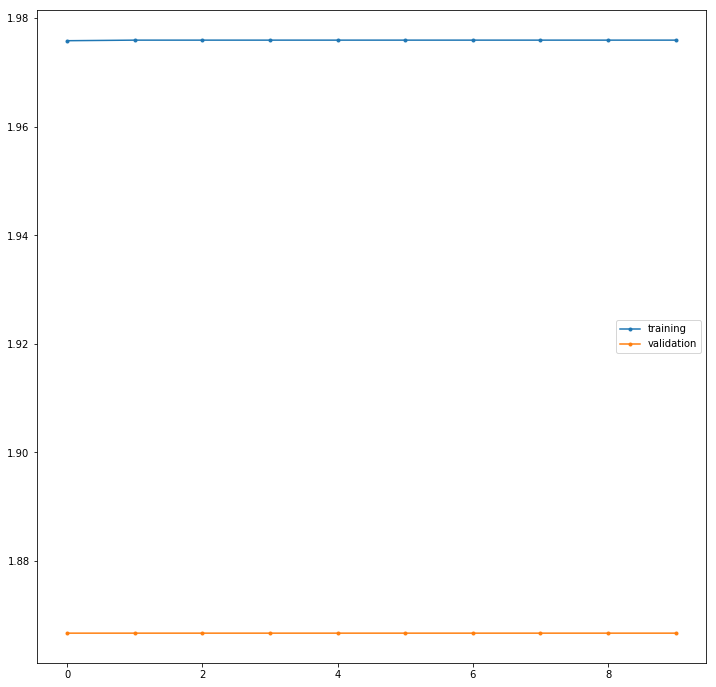

In [26]:
plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), training_error, '.-')
plt.plot(range(n_epochs), validation_error, '.-')
plt.legend(['training','validation'])

In [ ]:
def inference(layers, data_sample):
    # feedforward
    for t in range(unroll_factor):
        a = layers[0].forward(data_sample[t])
        for i in range(1,nlayers):
            a = layers[i].forward(a,t)
    return a

In [ ]:
for i in range(15):
    print(y_test[i,:])
    print(inference(layers,y_test[i,:]))